In [1]:
import seaborn as sb
import numpy as np
from matplotlib import pyplot as pl
sb.set()
sb.set_style('white')
cpal = sb.color_palette()

In [2]:
%load_ext jupyter_probcomp.magics

session_id: jovyan@nightcrawler2-notebook_2019-03-27T20:56:57.773303_A


In [3]:
%matplotlib inline
%vizgpm inline

<IPython.core.display.Javascript object>

In [4]:
%bayesdb -j wik_bdb/bdb_hunts_marr.bdb

u'Loaded: wik_bdb/bdb_hunts_marr.bdb'

In [14]:
%%bql
DROP TABLE IF EXISTS "dependence_probabilities";
CREATE TABLE "dependence_probabilities" AS
    ESTIMATE DEPENDENCE PROBABILITY
    FROM PAIRWISE VARIABLES OF bout_population;

""


In [15]:
%bql .interactive_heatmap SELECT * FROM "dependence_probabilities"

<IPython.core.display.Javascript object>

In [17]:
def scatter_simulated_vs_real_data(x, y):
    df_real = %bql SELECT  "{x}", "{y}"  FROM "bout_table"
    N = len(df_real)
    df_sim = %bql SIMULATE  "{x}", "{y}"  FROM "bout_population" LIMIT {N}
    fig, ax = pl.subplots(1, 1, figsize=(15,15))
    alpha = .4
    sb.scatterplot(df_real[x], df_real[y], ax=ax, color=cpal[0], alpha=alpha)
    sb.scatterplot(df_sim[x], df_sim[y], ax=ax, color=cpal[1], alpha=alpha)
    pl.show()
    return df_real, df_sim
    
    
def make_regression_plots(df_real, df_sim, labels, colors):
    fig, ax = pl.subplots(1,1, figsize=(15,15))
    x1 = df_real[labels[0]]
    y1 = df_real[labels[1]]
    x2 = df_sim[labels[0]]
    y2 = df_sim[labels[1]]
    plot1 = sb.regplot(np.array(x1),
                       np.array(y1), fit_reg=True,
                       n_boot=100, robust=False,
                       scatter_kws={'alpha': 0.15},
                       color=colors[0])
    plot2 = sb.regplot(np.array(x2),
                       np.array(y2), fit_reg=True,
                       n_boot=100,  robust=False,
                       scatter_kws={'alpha': 0.15},
                       color=colors[1])
    plot1.set_xlabel(labels[0], fontsize=16)
    plot1.set_ylabel(labels[1], fontsize=16)
    p1x, p1y = plot1.get_lines()[1].get_data()
    p2x, p2y = plot2.get_lines()[0].get_data()
    slope1 = np.around((p1y[1] - p1y[0])/(p1x[1] - p1x[0]), 2)
    slope2 = np.around((p2y[1] - p2y[0])/(p2x[1] - p2x[0]), 2)
    yint1 = np.around(p1y[1] - slope1*p1x[1], 2)
    yint2 = np.around(p2y[1] - slope2*p2x[1], 2)
    coeff1_nanfilt = np.array(
        [c1 for c1 in zip(x2, y2) if np.isfinite(c1).all()])
    coeff2_nanfilt = np.array([c2 for c2 in zip(
        x1, y1) if np.isfinite(c2).all()])
    coeff1 = np.around(pearsonr(coeff1_nanfilt[:, 0],
                                coeff1_nanfilt[:, 1])[0], 2)
    coeff2 = np.around(pearsonr(coeff2_nanfilt[:, 0],
                                coeff2_nanfilt[:, 1])[0], 2)
    xinit = np.min(p1x[0], p2x[0])
    plot1.text(xinit, 2.1, '  ' +
               str(slope2) + 'x + ' + str(
                   yint2) + ', ' + '$r^{2}$ = ' + str(coeff2**2),
               color=colors[1], fontsize=14)
    plot1.text(xinit, 1.7, '  ' +
               str(slope1) + 'x + ' + str(
                   yint1) + ', ' + '$r^{2}$ = ' + str(coeff1**2),
               color=colors[0], fontsize=14)
    if labels[1] != "Bout Distance" and labels[1] != "Postbout Para Distance":
        plot1.set_ylim([-2.5, 2.5])
    pl.show()
    return fig


1402


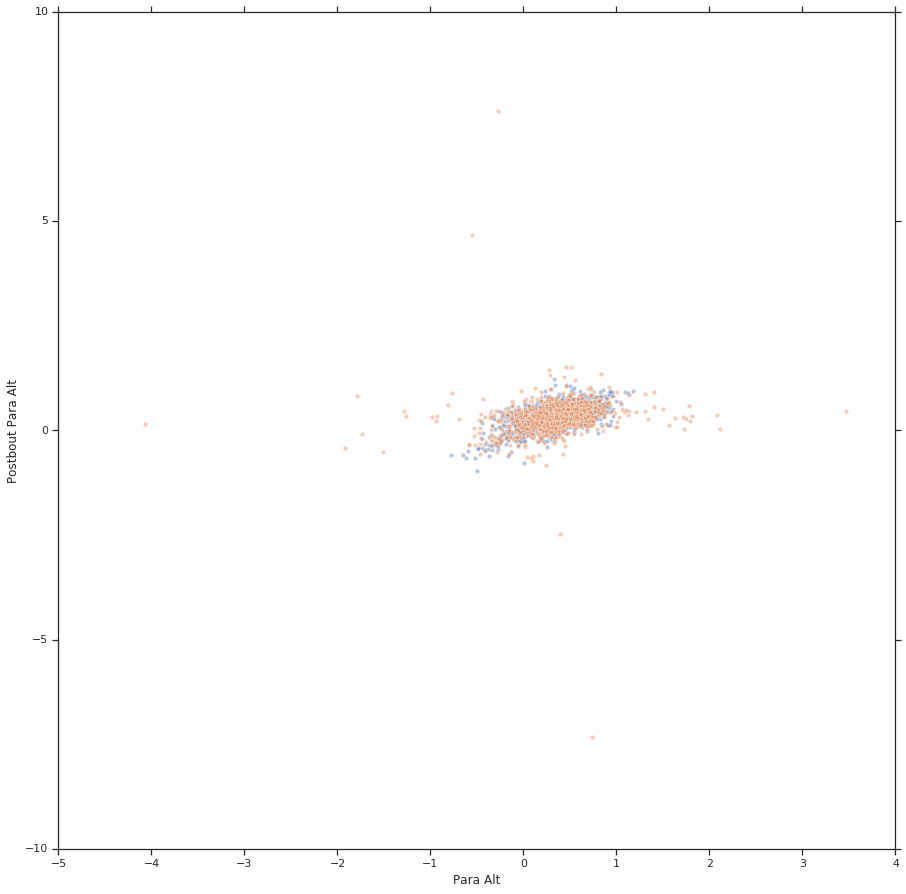

In [18]:
labels = ['Para Alt', 'Postbout Para Alt']
dfr, dfs = plot_simulated_vs_real_data(labels[0], labels[1])
make_regression_plots(dfr, dfs, labels, [cpal[0], cpal[1]])
